# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)

from xgboost import XGBRegressor

In [2]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [3]:
df = pd.read_csv('../../../input/df_raw_h19.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

,CPI,CPI Tradable,CPI Non-Tradable,CPI Core,CPI Non-Core,CPI Food and Energy,CPI Excluding Food and Energy,CPI Food and Beverages,CPI Excluding Food and Beverages,CPI Core Excluding Food and Beverages,...,Wholesale Price Index,Reserve Requirement Rate,Monetary Policy Rate,Circulating Currency Seasonally Adjusted (mill S/),Net International Reserves (mill $),Real Minimum Wage (Index),Wheat (US$ per ton),Corn (US$ per ton),Soybean oil (US$ per ton),Crude oil (US$ per barrel)
Fecha,,,,,,,,,,,,,,,,,,,,,
2019-08-01,0.155238,0.107169,0.182206,0.172176,0.120649,0.117414,0.187309,0.076524,0.207174,0.194464,...,-0.013811,6.446612,2.50,0.007826,0.022711,-0.000609,-0.071854,-0.127216,0.016693,-0.044064
2019-09-01,0.151966,0.103574,0.179086,0.168668,0.117677,0.111047,0.186615,0.065826,0.208745,0.190797,...,-0.029031,5.935527,2.50,0.008478,-0.005991,-0.000064,-0.028875,-0.044102,0.019052,0.037436
2019-10-01,0.148757,0.100074,0.176011,0.165254,0.114708,0.104757,0.185969,0.055385,0.210242,0.187204,...,-0.044027,6.617785,2.50,0.003873,0.001857,-0.001106,0.040636,0.066893,0.042443,-0.050909
2019-11-01,0.145714,0.096671,0.173140,0.161942,0.112035,0.098706,0.185426,0.045367,0.211728,0.183707,...,-0.058820,6.069958,2.25,0.006119,-0.017871,-0.001088,0.072377,-0.035344,0.026200,0.057743
2019-12-01,0.142886,0.093373,0.170545,0.158729,0.109809,0.092980,0.185001,0.035862,0.213221,0.180317,...,-0.073404,6.699655,2.25,0.029592,0.023139,-0.002141,0.032523,0.007789,0.057206,0.049040


In [4]:
df_lags = pd.read_csv('../../../input/df_lags_h19.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

,CPI,CPI Tradable_lag_1,CPI Tradable_lag_2,CPI Non-Tradable_lag_1,CPI Non-Tradable_lag_2,CPI Core_lag_1,CPI Core_lag_2,CPI Non-Core_lag_1,CPI Non-Core_lag_2,CPI Food and Energy_lag_1,...,Real Minimum Wage (Index)_lag_1,Real Minimum Wage (Index)_lag_2,Wheat (US$ per ton)_lag_1,Wheat (US$ per ton)_lag_2,Corn (US$ per ton)_lag_1,Corn (US$ per ton)_lag_2,Soybean oil (US$ per ton)_lag_1,Soybean oil (US$ per ton)_lag_2,Crude oil (US$ per barrel)_lag_1,Crude oil (US$ per barrel)_lag_2
Fecha,,,,,,,,,,,,,,,,,,,,,
2019-08-01,0.155238,0.110871,0.114674,0.185235,0.188145,0.175751,0.179341,0.123430,0.126055,0.123753,...,-0.002029,0.000863,-0.078909,0.071044,0.011487,0.168096,0.006573,0.042708,0.048935,-0.099863
2019-09-01,0.151966,0.107169,0.110871,0.182206,0.185235,0.172176,0.175751,0.120649,0.123430,0.117414,...,-0.000609,-0.002029,-0.071854,-0.078909,-0.127216,0.011487,0.016693,0.006573,-0.044064,0.048935
2019-10-01,0.148757,0.103574,0.107169,0.179086,0.182206,0.168668,0.172176,0.117677,0.120649,0.111047,...,-0.000064,-0.000609,-0.028875,-0.071854,-0.044102,-0.127216,0.019052,0.016693,0.037436,-0.044064
2019-11-01,0.145714,0.100074,0.103574,0.176011,0.179086,0.165254,0.168668,0.114708,0.117677,0.104757,...,-0.001106,-0.000064,0.040636,-0.028875,0.066893,-0.044102,0.042443,0.019052,-0.050909,0.037436
2019-12-01,0.142886,0.096671,0.100074,0.173140,0.176011,0.161942,0.165254,0.112035,0.114708,0.098706,...,-0.001088,-0.001106,0.072377,0.040636,-0.035344,0.066893,0.026200,0.042443,0.057743,-0.050909


## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

In [5]:
def get_RMSE(results):
    '''
    Objective:
        This function receives a DataFrame with both Actual and Predicted values and calculates the RMSE
        for each row.
        
    Input:
        results (DataFrame): DataFrame with 'Actual' and 'Predicted' columns.
        
    Output:
        A list containing RMSE for each row.
    '''
    RMSE = []

    for index, row in results.iterrows():
        sqr_err = (row['Actual'] - row['Predicted']) ** 2
        rmse = np.sqrt(sqr_err)
        RMSE.append(rmse)

    return RMSE

def get_MAPE(results):
    '''
    Objective:
        This function receives a DataFrame with both Actual and Predicted values and calculates the MAPE
        for each row.
        
    Input:
        results (DataFrame): DataFrame with 'Actual' and 'Predicted' columns.
        
    Output:
        A list containing MAPE for each row.
    '''
    MAPE = []

    for index, row in results.iterrows():
        per_err = abs((row['Actual'] - row['Predicted']) / row['Actual'])
        MAPE.append(per_err)

    return MAPE



### 3.1.1 Random Walk (RW)

In [6]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI'

# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2019-01-01']
test_set  = df_CPI[df_CPI.index >= '2019-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-h, 0]

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

,Horizon,Prediction
Fecha,,
2019-01-01,1,0.189323
2019-02-01,2,0.191548
2019-03-01,3,0.190254
2019-04-01,4,0.185983
2019-05-01,5,0.178815
2019-06-01,6,0.168479
2019-07-01,7,0.156857
2019-08-01,8,0.146404
2019-09-01,9,0.137154


In [7]:
# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Horizon,Predicted,Actual
Fecha,,,
2019-01-01,1,0.189323,0.183777
2019-02-01,2,0.191548,0.176969
2019-03-01,3,0.190254,0.172253
2019-04-01,4,0.185983,0.168370
2019-05-01,5,0.178815,0.164934
2019-06-01,6,0.168479,0.161702
2019-07-01,7,0.156857,0.158490
2019-08-01,8,0.146404,0.155238
2019-09-01,9,0.137154,0.151966


In [8]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

,RMSE_RW,MAPE_RW
1,0.005545,0.030174
2,0.011029,0.056278
3,0.013752,0.072352
4,0.014812,0.080417
5,0.014630,0.081167
6,0.013639,0.074624
7,0.012643,0.065435
8,0.012232,0.064369
9,0.012544,0.068047
10,0.013646,0.075435


### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [9]:
# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2019-01-01']
test_set  = df_CPI[df_CPI.index >= '2019-01-01']

In [10]:
# We find the best SARIMA model
autoarima = pmd.auto_arima(
        y = train_set,
        start_p=1,
        start_q=0,
        seasonal=True,
        max_p=12,
        max_d=1,
        max_q=6,
        max_P=12,
        max_D=1,
        max_Q=6,
        m=4,
        n_jobs=-1,
        suppress_warnings=True,
        )

# We indicate the seasonal order for monthly data
seasonal_order = (1, 1, 1, 12)

# We create our ARIMA model
model = SARIMAX(train_set,
                order=autoarima.order,
                seasonal_order=autoarima.seasonal_order,
                enforce_stationarity = False,
                enforce_invertibility = False)
        
# We fit the model
model_fit = model.fit()

# We forecast for the next 12 horizons
forecast_values = model_fit.get_forecast(steps=12)
predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'predicted_mean': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2019-01-01,0.185172,0.183777
2019-02-01,0.179394,0.176969
2019-03-01,0.171383,0.172253
2019-04-01,0.161631,0.168370
2019-05-01,0.151661,0.164934
2019-06-01,0.141873,0.161702
2019-07-01,0.132111,0.158490
2019-08-01,0.122488,0.155238
2019-09-01,0.113067,0.151966


In [11]:
# We get our metrics using our function
RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
metrics_arima

,RMSE_ARIMA,MAPE_ARIMA
1,0.001395,0.007589
2,0.001978,0.010646
3,0.001692,0.008782
4,0.003674,0.016592
5,0.006785,0.029368
6,0.010193,0.044911
7,0.013728,0.062273
8,0.017291,0.080860
9,0.020830,0.100317
10,0.024326,0.120442


### 3.1.3 Vector autoregression (VAR)

In [12]:
# We define our target variable, as well as our train and test set
target = 'CPI'
train_set = df[df.index < '2019-01-01']
test_set  = df[df.index >= '2019-01-01']

In [13]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(2)

In [14]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-2:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([preds, test_set[target]],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2019-01-01,0.140856,0.183777
2019-02-01,0.139105,0.176969
2019-03-01,0.137708,0.172253
2019-04-01,0.137287,0.168370
2019-05-01,0.138463,0.164934
2019-06-01,0.142064,0.161702
2019-07-01,0.149188,0.158490
2019-08-01,0.160861,0.155238
2019-09-01,0.177766,0.151966


In [15]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

,RMSE_VAR,MAPE_VAR
1,0.042921,0.233549
2,0.040472,0.223753
3,0.038597,0.216019
4,0.036863,0.208166
5,0.035032,0.198631
6,0.032969,0.185767
7,0.030725,0.167613
8,0.028809,0.151189
9,0.028491,0.153254
10,0.031539,0.172480


<AxesSubplot:>

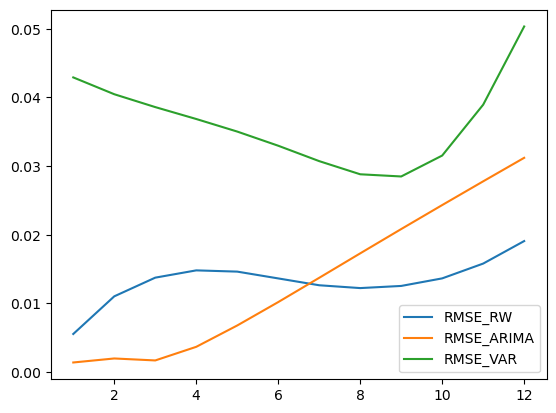

In [16]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [17]:
models = {
    
    'Lasso'        : { 'model'      : Lasso( random_state = 2023 ),
                       'grid_params': { 'alpha': [ 0.0001, 0.001, 0.01, 0.1 ] } },
    
    'Ridge'        : { 'model'      : Ridge( random_state = 2023 ),
                       'grid_params': { 'alpha': [ 0.0001, 0.001, 0.01, 0.1 ] } },
    
    'Elastic Net'  : { 'model'      : ElasticNet( random_state = 2023 ),
                       'grid_params': { 'alpha': [ 0.0001, 0.001, 0.01, 0.1 ], 'l1_ratio': np.arange(0.0, 1.0, 0.1) } },
    
    'Random Forest': { 'model'      : RandomForestRegressor( random_state = 2023, n_jobs = -1 ),
                       'grid_params': { 'n_estimators': [ 50, 100, 150, 200 ], 'max_depth': [10, 20, 30, 50] } },
    
    'Gradient Boosting': { 'model'  : XGBRegressor( random_state = 2023, n_jobs = -1 ),
                       'grid_params': { 'n_estimators': [ 50, 100, 150, 200 ], 'max_depth': [10, 20, 30, 50] } }
    
        }

In [18]:
# We define our target variable, as well as our train and test set
# ==============================================================================
steps = 12
target = 'CPI'
train_set = df_lags[:-steps]
test_set  = df_lags[-steps:]

In [23]:
y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

In [24]:
pred_vars = X_train.columns.to_list()

In [25]:
print(f"Training and tuning models...")

results = {
    'Model': [],
    'R2_train': [],
    'R2_test': [],
    'MAE_train': [],
    'MAE_test': [],
    'MAPE_train': [],
    'MAPE_test': [],
    'MSE_train': [],
    'MSE_test': [],
    'RMSE_train': [],
    'RMSE_test': [],
    'Grid_Search_Params': []
}

for model_name, model_params in models.items():
    print(f"Processing model: {model_name}")

    if 'model' in model_params:
        model = model_params['model']
    else:
        raise ValueError(f'Model is not defined for {model_name}')

    if 'grid_params' in model_params:
        grid_params = model_params['grid_params']
    else:
        grid_params = None

    best_params = None

    grid_search = GridSearchCV(model, grid_params, cv=None)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    if hasattr( best_model, 'feature_importances_' ):

        feature_importances = best_model.feature_importances_
        vars_df             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
        vars_df             = vars_df.reindex( vars_df[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
        vars_df.to_excel( f'varlist__{ model_name }.xlsx' )

    elif hasattr( best_model, 'coef_' ):

        coefficients = best_model.coef_[ 0 ]
        vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
        vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
        vars_df.to_excel( f'varlist_{ model_name }.xlsx' )
    else:
        best_model = model.fit(X_train, y_train)
        coefficients = best_model.coef_[ 0 ]
        vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
        vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
        vars_df.to_excel( f'varlist_{ model_name }.xlsx' )

        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        results = pd.concat([y_pred_test, y_test],axis=1)
        
        RMSE_test, MAPE_test = get_metrics(results, f'{model_name}')

        best_model_params = {
            'Model': model_name,
            'MAPE_test': MAPE_test,
            'RMSE_test': RMSE_test,
            'Grid_Search_Params': best_params
        }

        results['Model'].append(best_model_params['Model'])
        results['MAPE_test'].append(best_model_params['MAPE_test'])
        results['RMSE_test'].append(best_model_params['RMSE_test'])
        results['Grid_Search_Params'].append(best_model_params['Grid_Search_Params'])
        
print('Done')

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='RMSE_test', ascending=True)


Training and tuning models...
Processing model: Lasso
Processing model: Ridge
Processing model: Elastic Net
Processing model: Random Forest
Processing model: Gradient Boosting
Done


In [26]:
# forecaster = ForecasterAutoregMultiVariate(
#                  regressor = RandomForestRegressor(random_state=42),
#                  lags      = 2, # This value will be replaced in the grid search,
#     level = target,
#     steps = 2
#              )

# forecaster.fit()

# # Candidate values for lags
# lags_grid = [10, 20]

# # Candidate values for regressor's hyperparameters
# param_grid = {
#     'n_estimators': [100, 500],
#     'max_depth': [3, 5, 10]
# }

# results_grid = grid_search_forecaster(
#                    forecaster         = forecaster,
#                    y                  = test_set[target],
#                    level              = target,
#                    steps              = 2,
#                    param_grid         = param_grid,
#                    lags_grid          = lags_grid,
#                    steps              = steps,
#                    refit              = False,
#                    metric             = 'mean_squared_error',
#                    initial_train_size = 11,
#                    fixed_train_size   = False,
#                    return_best        = True,
#                    n_jobs             = 'auto',
#                    verbose            = False
#                )

In [27]:
# def test_models_regression(models, data, pred_vars, target_var ):
#     """
#     Evalúa modelos de regresión utilizando validación cruzada en series temporales.

#     Parámetros:
#     - modelos: Diccionario de modelos de regresión para evaluar.
#     - datos: DataFrame que contiene el conjunto de datos.
#     - variables_predictoras: Lista de nombres de variables predictoras.
#     - variable_objetivo: Nombre de la variable objetivo.

#     Retorna:
#     DataFrame: Resultados de la evaluación del modelo.
#     """       
#     results = {
#         'Model': [],
#         'R2_train': [],
#         'R2_test': [],
#         'MAE_train': [],
#         'MAE_test': [],
#         'MAPE_train': [],
#         'MAPE_test': [],
#         'MSE_train': [],
#         'MSE_test': [],
#         'RMSE_train': [],
#         'RMSE_test': [],
#         'Grid_Search_Params': []
#     }
    
#     X = data[pred_vars]
#     y = data[target_var]
    
#     cv = TimeSeriesSplit(n_splits=5)
    
#     print(f"Entrenando y evaluando modelos...")
    
#     for model_name, model_params in models.items():
#         print(f"Procesando el modelo: {model_name}")
        
#         if 'model' in model_params:
#             model = model_params['model']
#         else:
#             raise ValueError(f'Model is not defined for {model_name}')
        
#         if 'grid_params' in model_params:
#             grid_params = model_params['grid_params']
#         else:
#             grid_params = None
        
#         best_params = None
        
#         for ii, (tr, tt) in enumerate(cv.split(X, y)):
#             X_train, X_test = X.iloc[tr], X.iloc[tt]
#             y_train, y_test = y.iloc[tr], y.iloc[tt]
            
#             if ii == (cv.n_splits - 1):
            
#                 if grid_params is not None:
#                     grid_search = GridSearchCV(model, grid_params, cv=cv)
#                     grid_search.fit(X_train, y_train)
#                     best_model = grid_search.best_estimator_
#                     best_params = grid_search.best_params_

#                     if hasattr( best_model, 'feature_importances_' ):

#                         feature_importances = best_model.feature_importances_
#                         vars_df             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
#                         vars_df             = vars_df.reindex( vars_df[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
#                         vars_df.to_excel( f'varlist__{ model_name }.xlsx' )

#                     elif hasattr( best_model, 'coef_' ):

#                         coefficients = best_model.coef_[ 0 ]
#                         vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
#                         vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
#                         vars_df.to_excel( f'varlist_{ model_name }.xlsx' )
#                 else:
#                     best_model = model.fit(X_train, y_train)
#                     coefficients = best_model.coef_[ 0 ]
#                     vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
#                     vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
#                     vars_df.to_excel( f'varlist_{ model_name }.xlsx' )

#                 y_pred_train = best_model.predict(X_train)
#                 y_pred_test = best_model.predict(X_test)

#                 best_model_params = {
#                     'Model': model_name,
#                     'Grid_Search_Params': best_params
#                 }

#         results['Model'].append(best_model_params['Model'])
#         results['Grid_Search_Params'].append(best_model_params['Grid_Search_Params'])
    
#     results_df = pd.DataFrame(results)
#     results_df = results_df.sort_values(by='RMSE_test', ascending=True)

#     return results_df

In [28]:
# import pandas as pd
# from datetime import datetime, timedelta

# # Asumiendo que tu DataFrame tiene una columna 'timestamp' que representa la fecha
# # y que 'target_variable' es la variable que deseas predecir

# # 1. Filtra los datos hasta diciembre de 2018
# train_data = df[df['timestamp'] <= '2018-12-01']

# # 2. Filtra los últimos 12 meses para el conjunto de prueba
# test_start_date = datetime.strptime('2018-12-01', '%Y-%m-%d') + timedelta(days=1)
# test_data = df[(df['timestamp'] >= test_start_date) & (df['timestamp'] <= '2019-12-01')]

# # 3. Divide tus datos en características (X) y variable objetivo (y)
# X_train = train_data.drop('target_variable', axis=1)  # Ajusta 'target_variable' al nombre de tu variable objetivo
# y_train = train_data['target_variable']

# X_test = test_data.drop('target_variable', axis=1)
# y_test = test_data['target_variable']

# # Ahora tienes X_train, y_train para entrenar tu modelo hasta diciembre de 2018,
# # y X_test, y_test para evaluar tu modelo en los últimos 12 meses.
